# Module 05 Project Overview

The purpose of this project is to examine the relationship between hyperglycemic tests and hospital readmittance rates of patients with diabetes as a diagnosis. The model will attempt to predict which patients are likely to be readmitted for complications and categorized as being hospitalized within a month, more than a month from most recent discharge, and never. This model and similar models can change when testing is administered, possibly resulting in earlier diagnosis and preventative measures to be taken during the initial treatment period to avoid readmittance, lowering healthcare costs for both patient and hospital. 

This machine learning project is a supervised, multi-class classification problem.

You'll find the accompanying biomedical research paper with label descriptions and further information <a href="http://dx.doi.org/10.1155/2014/781670">here.</a>

In [1]:
import pandas as pd
import numpy as np
import pandas_profiling

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

In [2]:
raw_df = pd.read_csv("diabetes_data.csv")
df = pd.read_csv("diabetes_data.csv")

In [3]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [4]:
len(df)

101766

In [5]:
#df.profile_report()

## Preprocessing

In [6]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [7]:
df.drop(['weight','payer_code', 'citoglipton','examide'], inplace=True, axis=1) #Dropping weight since too few rows have actual values
 #Unnecessary for classification task
#Rejected - all "no"
#Rejected - all "no"

Because the medical specialty of the service provider could have influence on whether the H1bAlc test was performed, missing values will be replace with 'Unknown'.

In [8]:
df['medical_specialty'].replace(to_replace='?', value='Unknown', inplace=True)

In [9]:
df.race.value_counts(normalize=True)

Caucasian          0.747784
AfricanAmerican    0.188766
?                  0.022336
Hispanic           0.020017
Other              0.014799
Asian              0.006299
Name: race, dtype: float64

The following code replaces missing values in the race column with a random choice aligned with the probabilities of all other race options.

In [10]:
df['race'] = df['race'].apply(lambda x: np.random.choice(['Caucasian', 'AfricanAmerican','Hispanic', 'Other', 'Asian'], p=[0.76, 0.19, 0.02, 0.02, 0.01]) if x == '?' else x)

In [11]:
df.race.value_counts(normalize=True) #Confirming appropriate distribution

Caucasian          0.765226
AfricanAmerican    0.192658
Hispanic           0.020351
Other              0.015231
Asian              0.006535
Name: race, dtype: float64

In [12]:
df.gender.value_counts()

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

In [13]:
df = df[df.gender != 'Unknown/Invalid'] #dropping the three unknown gender rows

Due to my lack of medical knowledge, the following function will take in a column of ICD9 codes and replace them with the verbal diagnosis. This will help my understanding of the data. 

In [14]:
def diagnose(x):
    if (x >= 390) and (x <= 459) or (x == 785):
        return 'circulatory'
    
    elif (x >= 460) and (x <= 519) or (x == 786):
        return'respiratory'
    
    elif (x >= 520) and (x <= 579) or (x == 787):
        return 'digestive'
    
    elif (x >= 250) and (x <= 251):
        return 'diabetes'
    
    elif (x >= 800) and (x <= 999):
        return 'injury_poisoning'
    
    elif (x >= 710) and (x <= 739): 
        return 'musculoskeletal'
    
    elif (x >= 580) and (x <= 629) or (x == 788): 
        return 'genitourinary'
    
    elif (x >= 140) and (x <= 239): 
         return'neoplasms'
    
    elif (x >= 240) and (x <= 279): 
         return'endocrine_nutrition_metabolic'
    
    elif (x >= 680) and (x <= 709) or (x == 782): 
         return'skin_disease'
    
    elif (x >= 1) and (x <= 139): 
         return'infection_parasites'
    
    elif (x >= 290) and (x <= 319): 
        return 'mental'
    
    elif (x >= 0) and (x <1) or (x == 786): 
        return 'external_injury'
    
    elif (x >= 280) and (x <= 289):
        return 'blood'
    
    elif (x >= 320) and (x <= 359): 
        return 'nervous'
    
    elif (x >= 630) and (x <= 679):
        return 'pregnancy_childbirth'
    
    elif (x >= 360) and (x <= 389): 
        return 'sensory'
    
    elif (x >= 740) and (x <= 759):
        return 'congenital'
    
    elif (x >= 789) and (x <= 799) or (x == 780) or (x == 781) or (x == 784) or (x == 783):
        return 'other'
    else:
        return x

In [15]:
for col in ['diag_1', 'diag_2', 'diag_3']: 
    df[col] = [x.replace('V', "0.") for x in df[col]]
    df[col] = [x.replace('E', '0.') for x in df[col]]
    df[col] = [x.replace('?', '0') for x in df[col]]
    df[col] = df[col].astype(float)

In [16]:
df.diag_1 = df.diag_1.apply(diagnose)
df.diag_2 = df.diag_2.apply(diagnose)
df.diag_3 = df.diag_3.apply(diagnose)

In [17]:
for col in ['diag_1', 'diag_2', 'diag_3']:
    print(col, df[col].unique(), '\n\n')

diag_1 ['diabetes' 'endocrine_nutrition_metabolic' 'pregnancy_childbirth'
 'infection_parasites' 'neoplasms' 'circulatory' 'respiratory'
 'injury_poisoning' 'skin_disease' 'musculoskeletal' 'digestive'
 'external_injury' 'genitourinary' 'mental' 'other' 'nervous' 'blood'
 'sensory' 'congenital'] 


diag_2 ['external_injury' 'diabetes' 'neoplasms' 'circulatory' 'respiratory'
 'blood' 'injury_poisoning' 'musculoskeletal' 'genitourinary'
 'infection_parasites' 'endocrine_nutrition_metabolic' 'digestive'
 'skin_disease' 'nervous' 'other' 'mental' 'pregnancy_childbirth'
 'congenital' 'sensory'] 


diag_3 ['external_injury' 'endocrine_nutrition_metabolic' 'circulatory'
 'diabetes' 'infection_parasites' 'respiratory' 'injury_poisoning'
 'neoplasms' 'genitourinary' 'musculoskeletal' 'other' 'digestive'
 'skin_disease' 'mental' 'congenital' 'nervous' 'sensory'
 'pregnancy_childbirth' 'blood'] 




Keeping in line with the research paper, for patients who have had multiple encounters, each encounter past the first has been removed as they cannot be deemed statistically independent. 

In [18]:
df = df.drop_duplicates(subset=['patient_nbr'], keep='first')

## Exploratory Data Analysis

In [19]:
target = df.readmitted
features = df.drop('readmitted', axis=1)

In [20]:
#df.profile_report()

Since the problem we're trying to solve is classifying and predicting patients that received the H1BA1c hyperglycemia test and the likelihood that they will be readmitted for complications, we'll take a look at readmittance rates for those who have received and have not received the test. 

In [21]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [22]:
tested = df.loc[df.A1Cresult != 'None']
not_tested = df.loc[df.A1Cresult == 'None']

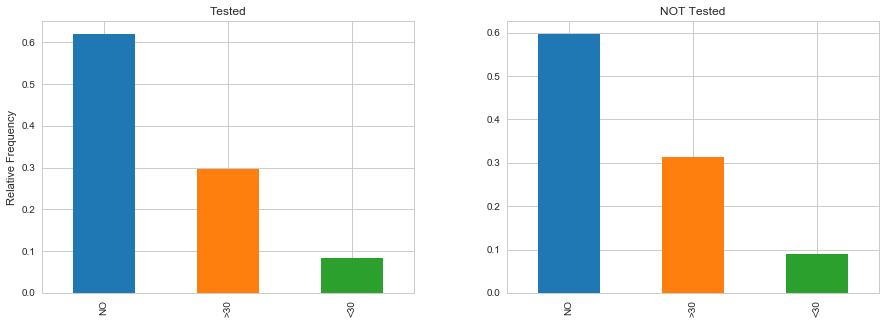

In [46]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
tested.readmitted.value_counts(normalize=True).plot(kind='bar', ax=ax1)
not_tested.readmitted.value_counts(normalize=True).plot(kind='bar', ax=ax2)
ax1.set_ylabel('Relative Frequency')
plt.subplots_adjust(wspace=.25)
ax1.set_title("Tested")
ax2.set_title("NOT Tested")

plt.show()

As you can see in the plots above, whether or not patients were tested for hyperglycemia, 40% of patients were readmitted. You can also observe the class disparity which will need to be remedied before modeling can begin.

Female    38025
Male      33490
Name: gender, dtype: int64


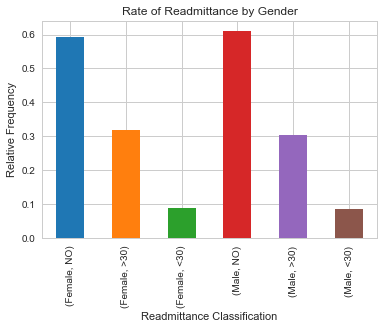

In [55]:
df.groupby(df.gender).readmitted.value_counts(normalize=True).plot(kind='bar', stacked=True)
plt.title('Rate of Readmittance by Gender')
plt.xlabel('Readmittance Classification')
plt.ylabel('Relative Frequency');
print(df.gender.value_counts())

More African American and Caucasian women are readmitted than men, however  , and both men and women are more often not readmitted, and lease likely to be readmitted within the thirty days following discharge. 

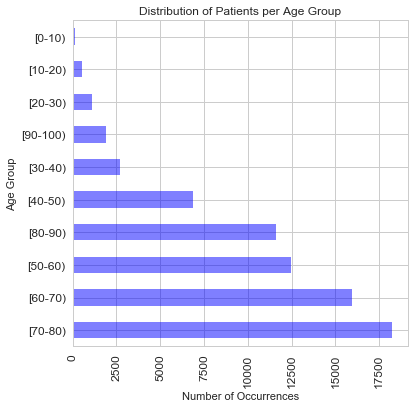

In [25]:
fig = plt.figure(figsize=(6,6))

df.age.value_counts().plot(kind='barh', color='blue', alpha=.5)
plt.title('Distribution of Patients per Age Group')
plt.ylabel('Age Group')
plt.xticks(rotation='vertical', size='large')
plt.yticks(size='large')
plt.xlabel('Number of Occurrences');

In [71]:
age_df

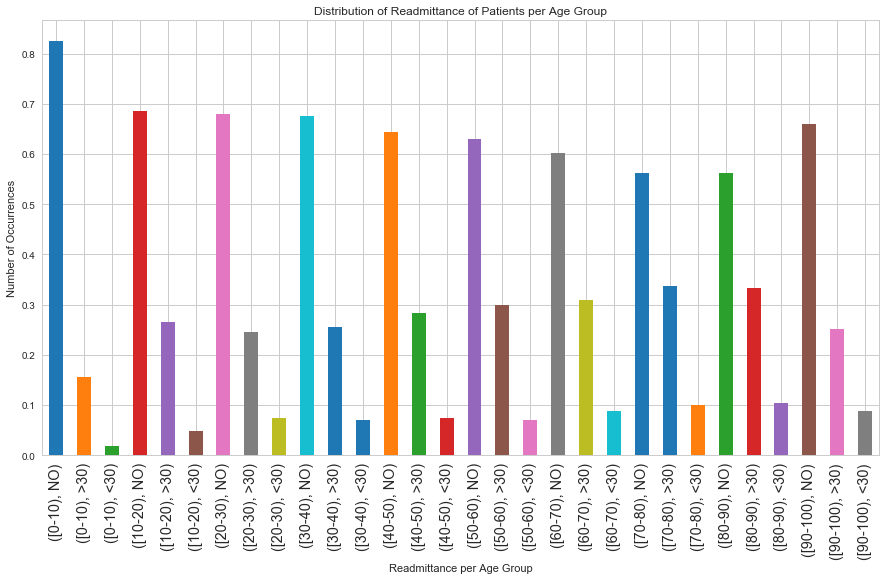

In [72]:
fig = plt.figure(figsize=(15,8))
age_df = df.groupby(df.age)

age_df.readmitted.value_counts(normalize=True).plot(kind='bar')
plt.title('Distribution of Readmittance of Patients per Age Group')
plt.xlabel('Readmittance per Age Group')
plt.xticks(rotation='vertical', size='x-large')
plt.ylabel('Number of Occurrences');

If you look closely, there is a general downward trend as patients increase in age for those who are not readmitted, while the rate of readmittance increases with age. There is another increase for patients who are 90-100 years old, though that may be due to the patient expiring or moving to hospice care.  

In [28]:
diabetes2 = tested.loc[tested['diag_2']=='diabetes'] 
diabetes2.loc[diabetes2['A1Cresult'] != 'None'].readmitted.value_counts(normalize=True)*100

NO     63.397129
>30    28.803828
<30     7.799043
Name: readmitted, dtype: float64

In [29]:
tested.groupby('diag_1').A1Cresult.value_counts(normalize=True)*100

diag_1                         A1Cresult
blood                          Norm         52.857143
                               >8           31.428571
                               >7           15.714286
circulatory                    >8           46.636012
                               Norm         29.235237
                               >7           24.128751
congenital                     >8           57.142857
                               >7           28.571429
                               Norm         14.285714
diabetes                       >8           73.493976
                               Norm         16.530120
                               >7            9.975904
digestive                      >8           42.216981
                               Norm         32.900943
                               >7           24.882075
endocrine_nutrition_metabolic  >8           43.333333
                               Norm         32.500000
                               >7        

## Preliminary Model

In [30]:
features.drop(['encounter_id','patient_nbr'], inplace=True, axis=1) #eliminating irrelevant ordinal data

In [31]:
features = features.astype('category', inplace=True)
features = pd.get_dummies(features)
len(features.columns)

566

In [32]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=.2)

In order for our models to work properly, we'll need to address the class imbalance of our target variable. 